In [18]:
#importing essential packages.
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm_notebook as tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## $1.1$ Reading Data

In [19]:
#Data taken from Kaggle: https://www.kaggle.com/manasvee1/donorschooseorg-application-screening

project_data = pd.read_csv('../input/donorschooseorg-application-screening/train.csv')
resource_data = pd.read_csv('../input/donorschooseorg-application-screening/resources.csv')

In [20]:
resource_data.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [21]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]

#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)

# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

## $1.2a$ preprocessing of `project_subject_categories`

In [22]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

## $1.2b$ preprocessing of `project_subject_subcategories`


In [23]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

## $1.2c$ preprocessing of `project_grade_category`

In [24]:
proj_grade_cat = []

for i in range(len(project_data)):
    pgc = project_data["project_grade_category"][i].replace(" ", "_")
    proj_grade_cat.append(pgc)
    
project_data.drop(['project_grade_category'], axis=1, inplace=True)
project_data["project_grade_category"] = proj_grade_cat

## $1.3$ Text preprocessing

In [25]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [26]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [27]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [28]:
def getProcessedData(txt_type, working_data):
    preprocessed_data = []
    # tqdm is for printing the status bar
    
    for sentance in tqdm(working_data[txt_type].values):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_data.append(sent.lower().strip())
        
    return preprocessed_data

<h2><font color='red'> $1.4$ For title </font></h2>

In [29]:
#Covered above

## $1.5$ Preparing data for models
we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### $1.5.1$ Response encoding for Categorical data

In [30]:
def trainResponseEncoding(working_data, cat_type): 
    # alpha, the hyperparameter of Laplace smoothing, has been defaulted to 1.
    
    working_data.loc[working_data[cat_type].isnull(), cat_type] = 'nan' #Imputation
    
    data_0 = working_data[working_data['project_is_approved']==0].groupby(cat_type).size()
    data_1 = working_data[working_data['project_is_approved']==1].groupby(cat_type).size()
    
    return data_0, data_1

def getResponseEnconding(data_0, data_1, working_data, cat_type, alpha=1):
    working_data.loc[working_data[cat_type].isnull(), cat_type] = 'nan' #if unseen data with isnull()==True found
    
    colwise_dict = {'col1':[], 'col2': []}
    
    for row in working_data[cat_type]:
        colwise_dict['col1'].append(data_0.get(row, 0.5))
        colwise_dict['col2'].append(data_1.get(row, 0.5))

    class_0 = ((data_0 + alpha)/(data_0 + data_1 + alpha)).values
    class_1 = ((data_1 + alpha)/(data_0 + data_1 + alpha)).values
    
    response_enc = pd.DataFrame(colwise_dict)
    print("Shape response encoding ",response_enc.shape)
    
    return response_enc

In [31]:
#getResponseEncoding(project_data, 'school_state')
#project_data.columns

### $1.5.2$ Vectorizing Text data

#### $1.5.2.1$ Bag of words

In [32]:
def getFitBOW_Vectorizer(preprocessed_data):
    vectorizer = CountVectorizer(ngram_range=(2,2), max_features=5000, min_df=10)
    vectorizer.fit(preprocessed_data)
    
    return vectorizer

def getBOWVectorizeTxtData(preprocessed_data, vectorizer):
    text_bow = vectorizer.transform(preprocessed_data)
    print("Shape of matrix after one hot encodig ",text_bow.shape)
    
    return text_bow

#### 1.5.2.2 TFIDF vectorizer

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

def getFitTFIDF_Vectorizer(preprocessed_data):
    vectorizer = TfidfVectorizer(ngram_range=(2,2), max_features=5000, min_df=10)
    vectorizer.fit(preprocessed_data)
    return vectorizer

def getTFIDFVectorizeTxtData(preprocessed_data, vectorizer):
    text_tfidf = vectorizer.transform(preprocessed_data)
    print("Shape of matrix after one hot encodig ",text_tfidf.shape)
    return text_tfidf

#### 1.5.2.3 Using Pretrained Models: Avg W2V

In [34]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('../input/glovevecto/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [35]:
def getAVG_W2V(preprocessed_data):
    avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    
    for sentence in tqdm(preprocessed_data): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)

    print(len(avg_w2v_vectors))
    print(len(avg_w2v_vectors[0]))
    
    return avg_w2v_vectors

#### $1.5.2.3$ Using Pretrained Models: TFIDF weighted W2V


In [36]:
def getFitTFIDF_W2V(preprocessed_data):
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(preprocessed_data)
    return tfidf_model

In [37]:
def getTFIDF_W2V(preprocessed_data, tfidf_model):
    
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(preprocessed_data): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)

    print(len(tfidf_w2v_vectors))
    print(len(tfidf_w2v_vectors[0]))
    
    return tfidf_w2v_vectors

### $1.5.3$ Vectorizing Numerical features


In [38]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [39]:
from sklearn.preprocessing import Normalizer
import warnings 
warnings.filterwarnings("ignore") 

def getFitNUM_Vectorizer(working_data, num_type):
    '''
    Fit on only train data.
    '''
    
    num_scalar = Normalizer()
    num_scalar.fit(working_data[num_type].values.reshape(-1,1)) # finding the mean and standard deviation of this data
    return num_scalar

def getNUM_Vectors(working_data, num_type, num_scalar):
    # Now standardize the data with above maen and variance.
    num_standardized = num_scalar.transform(working_data[num_type].values.reshape(-1, 1))
    
    return num_standardized

### $1.5.4$ Merging all the above features

In [40]:
from scipy.sparse import hstack

def getMergedFeatures(working_data, merge_on):
    valid_cols = []
    for key, value in working_data.items():
        if key in merge_on:
            valid_cols.append(value)
            #print (type(value), value.shape)
   
    return hstack(tuple(valid_cols))

<h1>$2.$  Random Forest and GBDT</h2>

<h2>$2.1$ Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [41]:

    
from sklearn.model_selection import train_test_split

#Classes of X & project_data have almost same proportion.
X = project_data[:50000]
y = X['project_is_approved']

#Breaking into only train and test as I am gonna use cross-validation.
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

<h2>$2.2$ Make Data Model Ready: encoding numerical, categorical features</h2>

In [42]:
data_dict = {'X_tr':{}, 'X_test': {} }
cols_dict = {    'cat_cols': ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category','teacher_prefix'],
                 'num_cols': ['price', 'teacher_number_of_previously_posted_projects']
            }
# 
#'school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix'
for col_type, cols_name in cols_dict.items():
    if col_type == 'cat_cols':
        for cat_type in cols_name:
            print (cat_type)
            data_0, data_1 = trainResponseEncoding(X_tr, cat_type)
            for data_type, data_part in [('X_tr', X_tr), ('X_test', X_test)]:
                response_encode = getResponseEnconding(data_0, data_1, data_part, cat_type)
                data_dict[data_type][cat_type] = response_encode
    else:
        for num_type in cols_name:
            vectorizer = getFitNUM_Vectorizer(X_tr, num_type)
            for data_type, data_part in [('X_tr', X_tr), ('X_test', X_test)]:
                num_vectors = getNUM_Vectors(data_part, num_type, vectorizer)
                data_dict[data_type][num_type] = num_vectors
        

school_state
Shape response encoding  (35000, 2)
Shape response encoding  (15000, 2)
clean_categories
Shape response encoding  (35000, 2)
Shape response encoding  (15000, 2)
clean_subcategories
Shape response encoding  (35000, 2)
Shape response encoding  (15000, 2)
project_grade_category
Shape response encoding  (35000, 2)
Shape response encoding  (15000, 2)
teacher_prefix
Shape response encoding  (35000, 2)
Shape response encoding  (15000, 2)


<h2>$2.3$ Make Data Model Ready: encoding eassay, and project_title</h2>

In [43]:
for col_type in ['essay','project_title']:
    for data_type, data_part in [('X_tr', X_tr), ('X_test', X_test)]:
        preprocessed_data = getProcessedData(col_type, data_part)
        
        if data_type == 'X_tr':
            vectorizer_bog = getFitBOW_Vectorizer(preprocessed_data)
        text_bow = getBOWVectorizeTxtData(preprocessed_data, vectorizer_bog)
        data_dict[data_type]['%s_text_bow'%col_type] = text_bow
        
        if data_type == 'X_tr':
            vectorizer_tfidf = getFitTFIDF_Vectorizer(preprocessed_data)
        text_tfidf = getTFIDFVectorizeTxtData(preprocessed_data, vectorizer_tfidf)
        data_dict[data_type]['%s_text_tfidf'%col_type] = text_tfidf
        
        text_w2v = getAVG_W2V(preprocessed_data)
        data_dict[data_type]['%s_text_w2v'%col_type] = text_w2v
        
        if data_type == 'X_tr':
            vectorizer_tfidfw2v = getFitTFIDF_W2V(preprocessed_data)
        text_tfidfw2v = getTFIDF_W2V(preprocessed_data, vectorizer_tfidfw2v)
        data_dict[data_type]['%s_text_tfidfw2v'%col_type] = text_tfidfw2v
    


Shape of matrix after one hot encodig  (35000, 5000)
Shape of matrix after one hot encodig  (35000, 5000)



35000
300



35000
300



Shape of matrix after one hot encodig  (15000, 5000)
Shape of matrix after one hot encodig  (15000, 5000)



15000
300



15000
300



Shape of matrix after one hot encodig  (35000, 878)
Shape of matrix after one hot encodig  (35000, 878)



35000
300



35000
300



Shape of matrix after one hot encodig  (15000, 878)
Shape of matrix after one hot encodig  (15000, 878)



15000
300



15000
300


<h2>2.4 Applying Random Forest</h2>


In [44]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, auc

In [45]:
def getAUCs(data_pnts_tr, y_tr, parameters, flag=0):
    auc_tr = []
    auc_cv = []
    
    if flag:
        model = xgb.XGBClassifier()
    else:
        model = RandomForestClassifier(class_weight='balanced')

    clf = GridSearchCV(model, param_grid=parameters, cv=3, scoring='roc_auc', return_train_score=True, n_jobs=20)
    clf.fit(data_pnts_tr, y_tr)
    #print (clf)
    auc_tr = clf.cv_results_['mean_train_score']
    auc_tr_std = clf.cv_results_['std_train_score']
    auc_cv = clf.cv_results_['mean_test_score'] 
    auc_cv_std= clf.cv_results_['std_test_score']
    #list(itertools.product(depth, min_samples_split))
    return auc_tr, auc_cv

def plotPerformance3d(hyper1, hyper2, auc_tr1, auc_cv1, plt_title):
    rows = hyper1
    cols = hyper2
    cm_tr = np.array(auc_tr1).reshape((len(rows), len(cols)))
    df_tr = pd.DataFrame(cm_tr, columns=cols, index=rows)
    cm_cv = np.array(auc_cv1).reshape((len(rows), len(cols)))
    df_cv = pd.DataFrame(cm_cv, columns=cols, index=rows)
    
    plt.figure(figsize=(15, 15))

    ax_tr = plt.subplot(221)
    sns.heatmap(df_tr, annot=True, ax=ax_tr, fmt='g')
    ax_tr.set_xlabel('n_estimators')
    ax_tr.set_ylabel('max_depth')
    plt.title("Training data's AUCs on various depth & n_estimators using %s on text features"%plt_title)
    
    ax_cv = plt.subplot(222)
    sns.heatmap(df_cv, annot=True, ax=ax_cv, fmt='g')
    ax_cv.set_xlabel('n_estimators')
    ax_cv.set_ylabel('max_depth')
    plt.title("CV data's AUCs on various depth & n_estimators using %s on text features"%plt_title)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    plt.show()

In [46]:
from sklearn import metrics

def trainOnOptimalHP(optimal_c, X_tr, y_tr, flag=0):
    if flag:
        model = xgb.XGBClassifier()
    else:
        model = RandomForestClassifier(max_depth=optimal_c[0], min_samples_split=optimal_c[1], class_weight='balanced')
    model.fit(X_tr, y_tr)
    return model

def getROC_Data(data_pnts_test, y_test, data_pnts_tr, y_tr, model):
    
    predicted_y_test = model.predict_proba(data_pnts_test)[:, 1]
    predicted_y_tr = model.predict_proba(data_pnts_tr)[:, 1]
    
    fpr_test, tpr_test, thres_test = roc_curve(y_test, predicted_y_test)
    fpr_tr, tpr_tr, thres_tr = roc_curve(y_tr, predicted_y_tr)
    
    return [fpr_test, tpr_test, thres_test], [fpr_tr, tpr_tr, thres_tr]
    
def makeROC(test_data, train_data, plt_title):
    fpr_tr, tpr_tr, _ = train_data
    fpr_test, tpr_test, _ = test_data
    
    plt.plot(fpr_tr, tpr_tr, label='AUC_Train: %s'%auc(train_data[0],train_data[1]))
    plt.plot(fpr_test, tpr_test, label='AUC_Test: : %s'%auc(test_data[0],test_data[1]))
    plt.title("ROC Curve using %s on text features"%plt_title)
    
    plt.xlabel('FPT')
    plt.ylabel('TPR')
    plt.legend()
    

In [47]:
#Reference: https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
#fmt='g' reason: https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
from sklearn.metrics import confusion_matrix

def getConfusionMatrix(svm, data_pnts_test, y_true, plt_title):
    y_pred = svm.predict(data_pnts_test)
    
    cm = confusion_matrix(y_true, y_pred) # Predicted values are column wise!
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g')
    
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('Actual Labels')
    ax.set_title('Confusion Matrix using %s on text features'%plt_title)
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])
    

In [48]:
rf_n_estimators = [10, 100, 500] 
rf_max_depths =  [10, 50, 100, 500, 1000]
rf_parameters = {  'max_depth': rf_max_depths, 
                    'n_estimators': rf_n_estimators }
                #'return_train_score': True }

### $2.4.1$ Apply RF on BOW,<font color='red'> SET $1$</font>

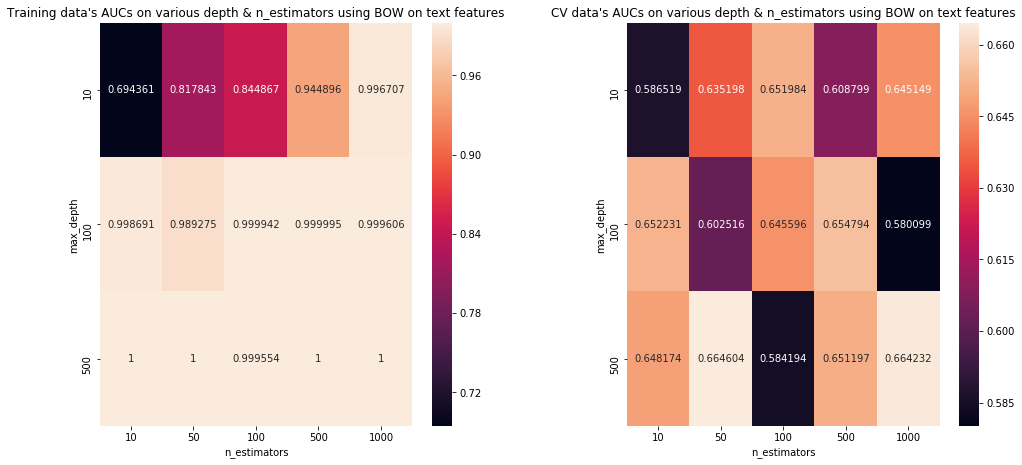

In [49]:
rf_set1_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_bow', 'project_title_text_bow']
rf_plt_title1 = 'BOW'

rf_data_pnts_tr1 = getMergedFeatures(data_dict['X_tr'], rf_set1_cols)
rf_data_pnts_test1 = getMergedFeatures(data_dict['X_test'], rf_set1_cols)

rf_auc_tr1, rf_auc_cv1 = getAUCs(rf_data_pnts_tr1, y_tr, rf_parameters)
plotPerformance3d(rf_n_estimators, rf_max_depths, rf_auc_tr1, rf_auc_cv1, rf_plt_title1)
rf_optimal_hypers1 = (10, 50)
rft1 = trainOnOptimalHP(rf_optimal_hypers1, rf_data_pnts_tr1, y_tr)
rf_roc_data_test1, rf_roc_data_train1 = getROC_Data(rf_data_pnts_test1, y_test, rf_data_pnts_tr1, y_tr, rft1)

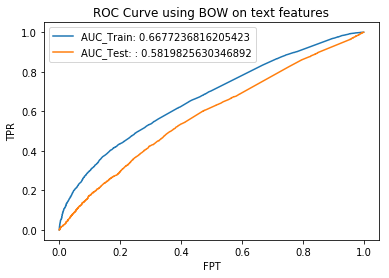

In [50]:
makeROC(rf_roc_data_test1, rf_roc_data_train1, rf_plt_title1)

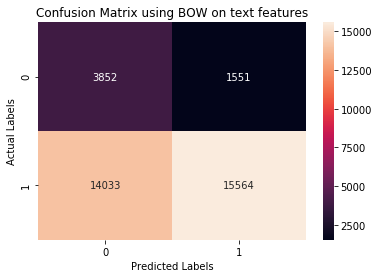

In [51]:
getConfusionMatrix(rft1, rf_data_pnts_tr1, y_tr, rf_plt_title1)

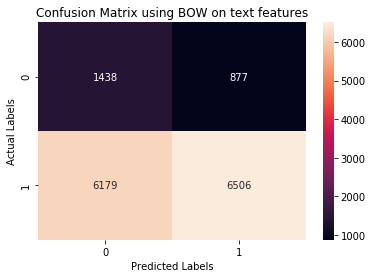

In [52]:
getConfusionMatrix(rft1, rf_data_pnts_test1, y_test, rf_plt_title1)

### $2.4.$2 Applying RF on TFIDF,<font color='red'> SET $2$</font>

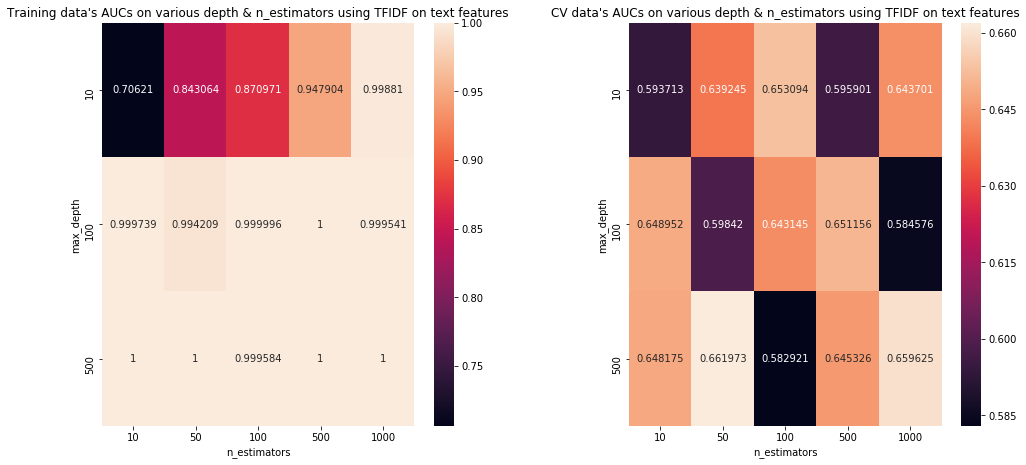

In [53]:
rf_set2_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_tfidf', 'project_title_text_tfidf']
rf_plt_title2 = 'TFIDF'

rf_data_pnts_tr2 = getMergedFeatures(data_dict['X_tr'], rf_set2_cols)
rf_data_pnts_test2 = getMergedFeatures(data_dict['X_test'], rf_set2_cols)

rf_auc_tr2, rf_auc_cv2 = getAUCs(rf_data_pnts_tr2, y_tr, rf_parameters)
plotPerformance3d(rf_n_estimators, rf_max_depths, rf_auc_tr2, rf_auc_cv2, rf_plt_title2)
rf_optimal_alpha2 = (10, 50)
rft2 = trainOnOptimalHP(rf_optimal_alpha2, rf_data_pnts_tr2, y_tr)
rf_roc_data_test2, rf_roc_data_train2 = getROC_Data(rf_data_pnts_test2, y_test, rf_data_pnts_tr2, y_tr, rft2)

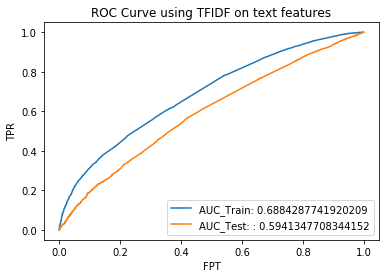

In [54]:
makeROC(rf_roc_data_test2, rf_roc_data_train2, rf_plt_title2)

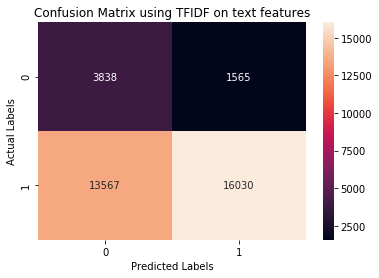

In [55]:
getConfusionMatrix(rft2, rf_data_pnts_tr2, y_tr, rf_plt_title2)

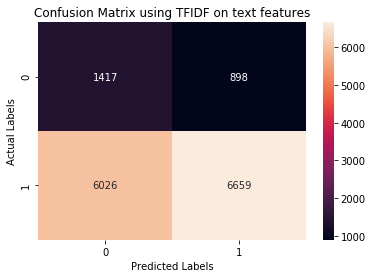

In [56]:
getConfusionMatrix(rft2, rf_data_pnts_test2, y_test, rf_plt_title2)

### $2.4.3$ Applying RF on AVG W2V,<font color='red'> SET $3$</font>

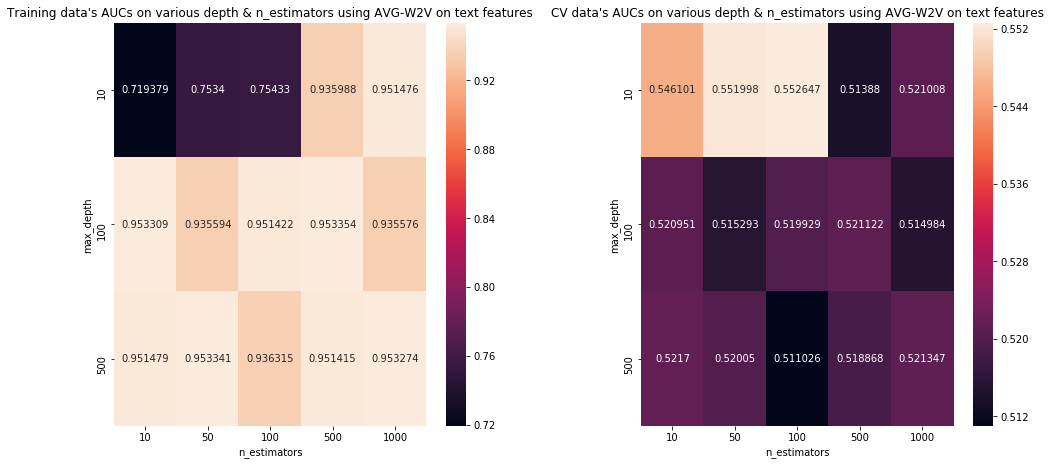

In [57]:
rf_set3_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_avgW2V', 'project_title_text_avgW2V']
rf_plt_title3 = "AVG-W2V"

rf_data_pnts_tr3 = getMergedFeatures(data_dict['X_tr'], rf_set3_cols)
rf_data_pnts_test3 = getMergedFeatures(data_dict['X_test'], rf_set3_cols)

rf_auc_tr3, rf_auc_cv3 = getAUCs(rf_data_pnts_tr3, y_tr, rf_parameters)
plotPerformance3d(rf_n_estimators, rf_max_depths, rf_auc_tr3, rf_auc_cv3, rf_plt_title3)
rf_optimal_alpha3 = (10, 100)
rft3 = trainOnOptimalHP(rf_optimal_alpha3, rf_data_pnts_tr3, y_tr)
rf_roc_data_test3, rf_roc_data_train3 = getROC_Data(rf_data_pnts_test3, y_test, rf_data_pnts_tr3, y_tr, rft3)

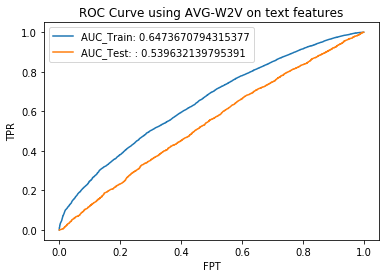

In [58]:
makeROC(rf_roc_data_test3, rf_roc_data_train3, rf_plt_title3)

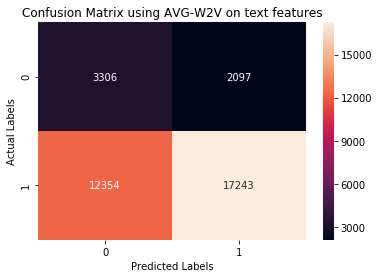

In [59]:
getConfusionMatrix(rft3, rf_data_pnts_tr3, y_tr, rf_plt_title3)

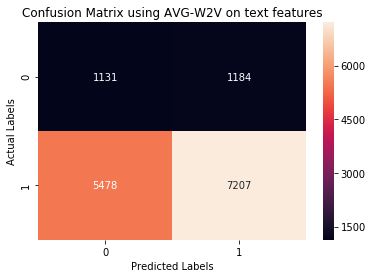

In [60]:
getConfusionMatrix(rft3, rf_data_pnts_test3, y_test, rf_plt_title3)

### $2.4.4$ Applying RF on TFIDF W2V,<font color='red'> SET $4$</font>

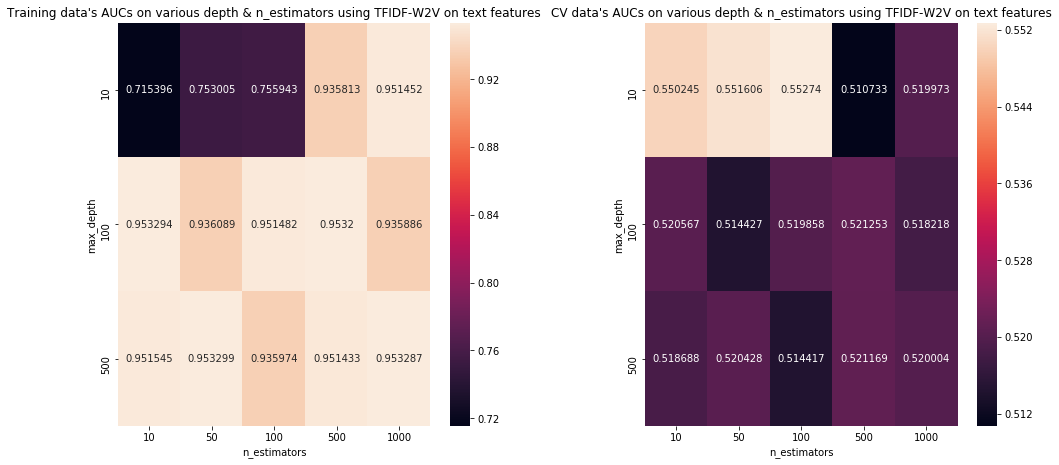

In [61]:
rf_set4_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_tfidfW2V', 'project_title_text_tfidfW2V']
rf_plt_title4 = "TFIDF-W2V"

rf_data_pnts_tr4 = getMergedFeatures(data_dict['X_tr'], rf_set4_cols)
rf_data_pnts_test4 = getMergedFeatures(data_dict['X_test'], rf_set4_cols)

rf_auc_tr4, rf_auc_cv4 = getAUCs(rf_data_pnts_tr4, y_tr, rf_parameters)
plotPerformance3d(rf_n_estimators, rf_max_depths, rf_auc_tr4, rf_auc_cv4, rf_plt_title4)
rf_optimal_alpha4 = (10, 50)
rft4 = trainOnOptimalHP(rf_optimal_alpha4, rf_data_pnts_tr4, y_tr)
rf_roc_data_test4, rf_roc_data_train4 = getROC_Data(rf_data_pnts_test4, y_test, rf_data_pnts_tr4, y_tr, rft4)

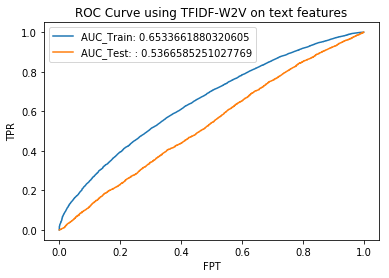

In [62]:
makeROC(rf_roc_data_test4, rf_roc_data_train4, rf_plt_title4)

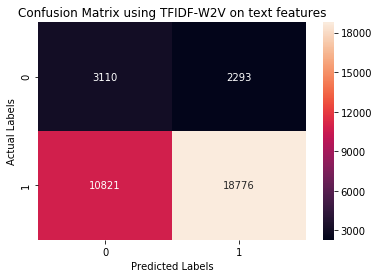

In [63]:
getConfusionMatrix(rft4, rf_data_pnts_tr4, y_tr, rf_plt_title4)

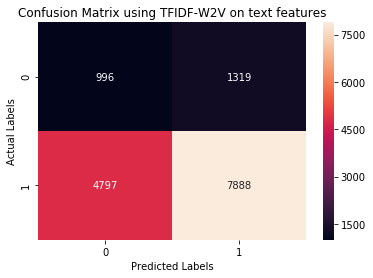

In [64]:
getConfusionMatrix(rft4, rf_data_pnts_test4, y_test, rf_plt_title4)

<h2>2.5 Applying GBDT</h2>


In [65]:
gbdt_n_estimators = [5, 10]
gbdt_max_depths =  [10, 50, 100, 500, 1000]
gbdt_parameters = {  'max_depth': gbdt_max_depths, 
                    'n_estimators': gbdt_n_estimators }

### $2.5.1$ Applying XGBOOST on BOW,<font color='red'> SET $1$</font>

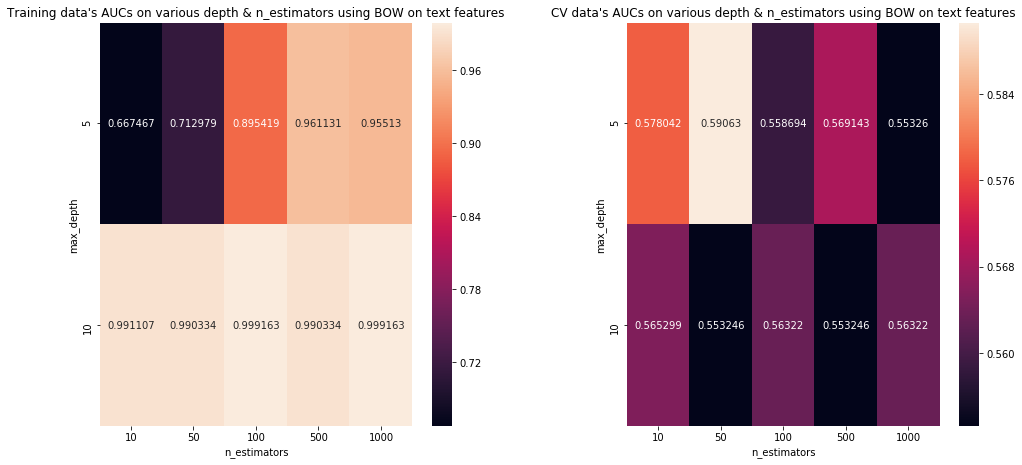

In [66]:
gbdt_set1_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_bow', 'project_title_text_bow']
gbdt_plt_title1 = 'BOW'

gbdt_data_pnts_tr1 = getMergedFeatures(data_dict['X_tr'], gbdt_set1_cols)
gbdt_data_pnts_test1 = getMergedFeatures(data_dict['X_test'], gbdt_set1_cols)

gbdt_auc_tr1, gbdt_auc_cv1 = getAUCs(gbdt_data_pnts_tr1, y_tr, gbdt_parameters, 1)
plotPerformance3d(gbdt_n_estimators, gbdt_max_depths, gbdt_auc_tr1, gbdt_auc_cv1, gbdt_plt_title1)
gbdt_optimal_hypers1 = (5, 500)
gbdt1 = trainOnOptimalHP(gbdt_optimal_hypers1, gbdt_data_pnts_tr1, y_tr)
gbdt_roc_data_test1, gbdt_roc_data_train1 = getROC_Data(gbdt_data_pnts_test1, y_test, gbdt_data_pnts_tr1, y_tr, gbdt1)

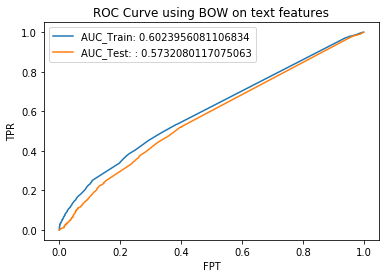

In [67]:
makeROC(gbdt_roc_data_test1, gbdt_roc_data_train1, gbdt_plt_title1)

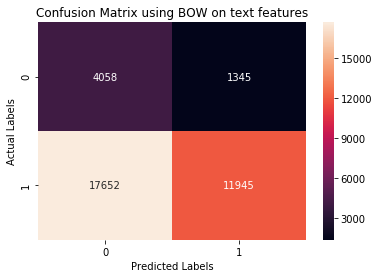

In [68]:
getConfusionMatrix(gbdt1, gbdt_data_pnts_tr1, y_tr, gbdt_plt_title1)

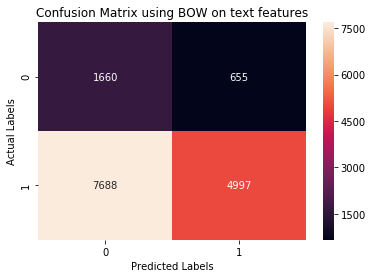

In [69]:
getConfusionMatrix(gbdt1, gbdt_data_pnts_test1, y_test, gbdt_plt_title1)

### $2.5.2$ Applying XGBOOST on TFIDF,<font color='red'> SET $2$</font>

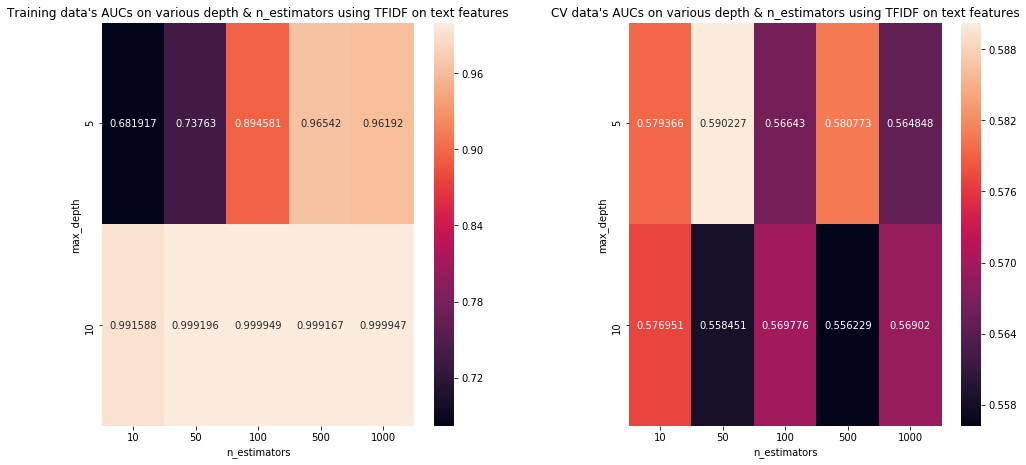

In [70]:
gbdt_set2_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_tfidf', 'project_title_text_tfidf']
gbdt_plt_title2 = 'TFIDF'

gbdt_data_pnts_tr2 = getMergedFeatures(data_dict['X_tr'], gbdt_set2_cols)
gbdt_data_pnts_test2 = getMergedFeatures(data_dict['X_test'], gbdt_set2_cols)

gbdt_auc_tr2, gbdt_auc_cv2 = getAUCs(gbdt_data_pnts_tr2, y_tr, gbdt_parameters, 1)
plotPerformance3d(gbdt_n_estimators, gbdt_max_depths, gbdt_auc_tr2, gbdt_auc_cv2, gbdt_plt_title2)
gbdt_optimal_hypers2 = (5, 50)
gbdt2 = trainOnOptimalHP(gbdt_optimal_hypers2, gbdt_data_pnts_tr2, y_tr)
gbdt_roc_data_test2, gbdt_roc_data_train2 = getROC_Data(gbdt_data_pnts_test2, y_test, gbdt_data_pnts_tr2, y_tr, gbdt2)

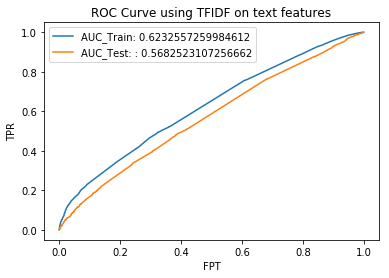

In [71]:
makeROC(gbdt_roc_data_test2, gbdt_roc_data_train2, gbdt_plt_title2)

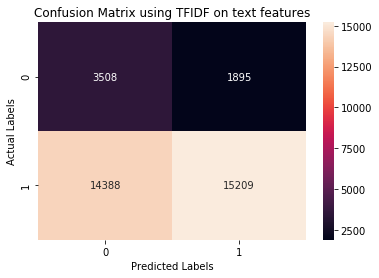

In [72]:
getConfusionMatrix(gbdt2, gbdt_data_pnts_tr2, y_tr, gbdt_plt_title2)

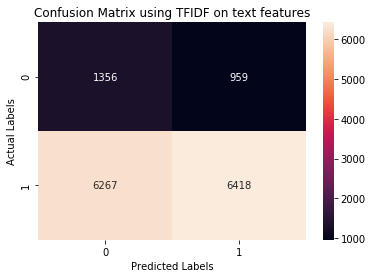

In [73]:
getConfusionMatrix(gbdt2, gbdt_data_pnts_test2, y_test, gbdt_plt_title2)

### $2.5.3$ Applying XGBOOST on AVG W2V,<font color='red'> SET $3$</font>

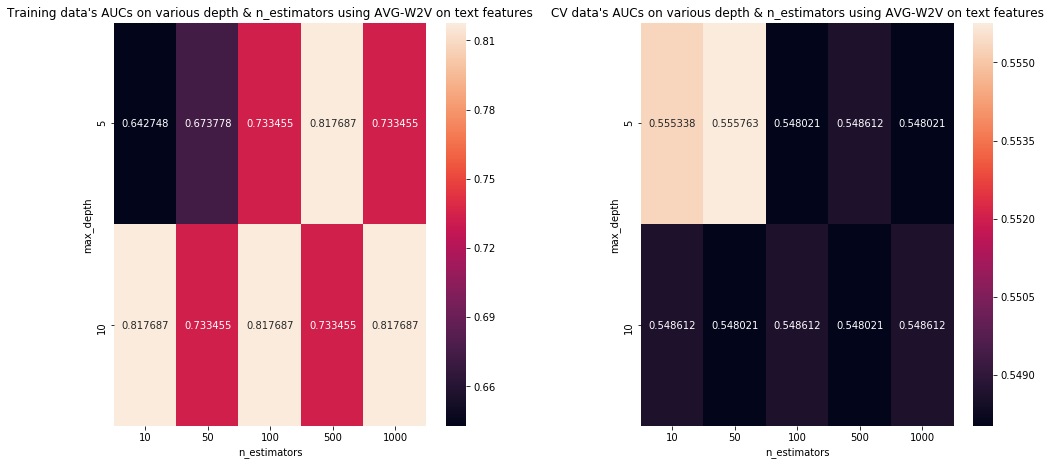

In [74]:
gbdt_set3_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_avgW2V', 'project_title_text_avgW2V']
gbdt_plt_title3 = "AVG-W2V"

gbdt_data_pnts_tr3 = getMergedFeatures(data_dict['X_tr'], gbdt_set3_cols)
gbdt_data_pnts_test3 = getMergedFeatures(data_dict['X_test'], gbdt_set3_cols)

gbdt_auc_tr3, gbdt_auc_cv3 = getAUCs(gbdt_data_pnts_tr3, y_tr, gbdt_parameters, 1)
plotPerformance3d(gbdt_n_estimators, gbdt_max_depths, gbdt_auc_tr3, gbdt_auc_cv3, gbdt_plt_title3)
gbdt_optimal_hypers3 = (5, 50)
gbdt3 = trainOnOptimalHP(gbdt_optimal_hypers3, gbdt_data_pnts_tr3, y_tr)
gbdt_roc_data_test3, gbdt_roc_data_train3 = getROC_Data(gbdt_data_pnts_test3, y_test, gbdt_data_pnts_tr3, y_tr, gbdt3)

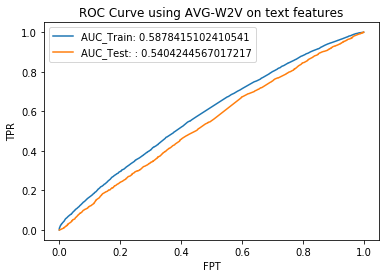

In [75]:
makeROC(gbdt_roc_data_test3, gbdt_roc_data_train3, gbdt_plt_title3)

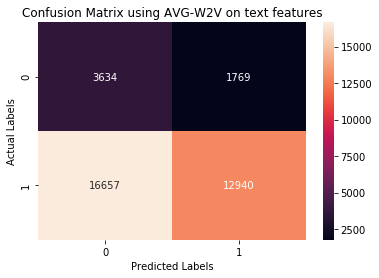

In [76]:
getConfusionMatrix(gbdt3, gbdt_data_pnts_tr3, y_tr, gbdt_plt_title3)

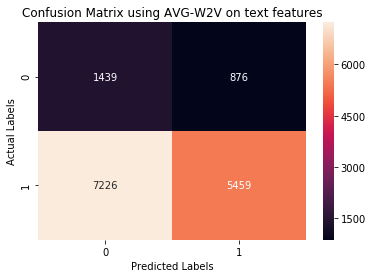

In [77]:
getConfusionMatrix(gbdt3, gbdt_data_pnts_test3, y_test, gbdt_plt_title3)

### $2.5.4$ Applying XGBOOST on TFIDF W2V,<font color='red'> SET $4$</font>

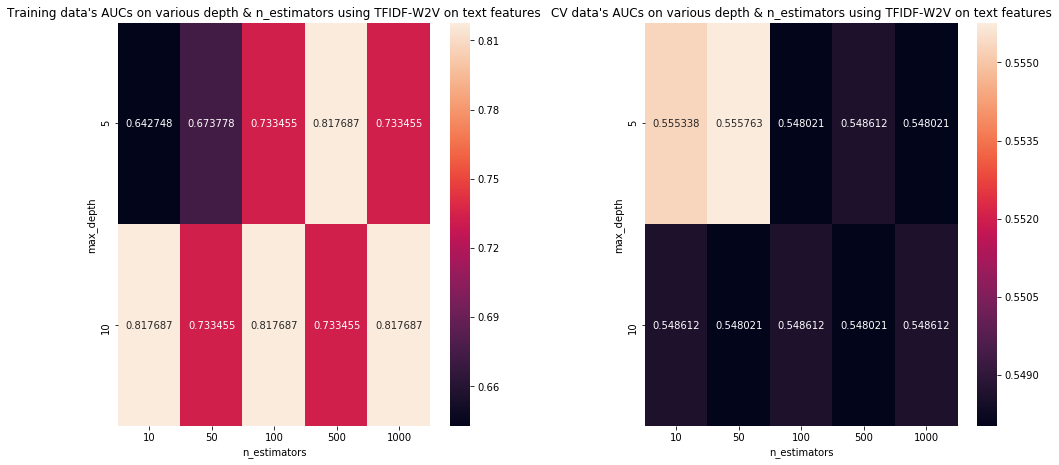

In [78]:
gbdt_set4_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_tfidfW2V', 'project_title_text_tfidfW2V']
gbdt_plt_title4 = "TFIDF-W2V"

gbdt_data_pnts_tr4 = getMergedFeatures(data_dict['X_tr'], gbdt_set4_cols)
gbdt_data_pnts_test4 = getMergedFeatures(data_dict['X_test'], gbdt_set4_cols)

gbdt_auc_tr4, gbdt_auc_cv4 = getAUCs(gbdt_data_pnts_tr4, y_tr, gbdt_parameters, 1)
plotPerformance3d(gbdt_n_estimators, gbdt_max_depths, gbdt_auc_tr4, gbdt_auc_cv4, gbdt_plt_title4)
gbdt_optimal_hypers4 = (5, 50)
gbdt4 = trainOnOptimalHP(gbdt_optimal_hypers4, gbdt_data_pnts_tr4, y_tr)
gbdt_roc_data_test4, gbdt_roc_data_train4 = getROC_Data(gbdt_data_pnts_test4, y_test, gbdt_data_pnts_tr4, y_tr, gbdt4)

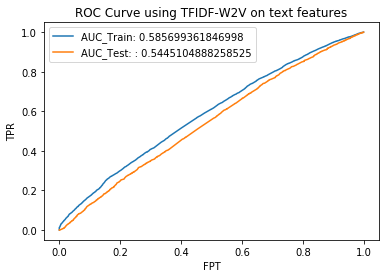

In [79]:
makeROC(gbdt_roc_data_test4, gbdt_roc_data_train4, gbdt_plt_title4)

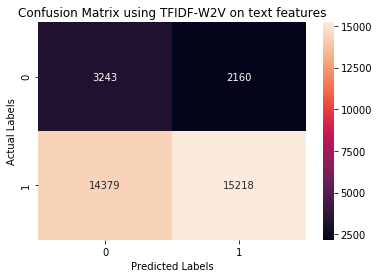

In [80]:
getConfusionMatrix(gbdt4, gbdt_data_pnts_tr4, y_tr, gbdt_plt_title4)

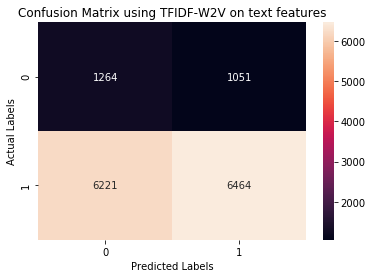

In [81]:
getConfusionMatrix(gbdt4, gbdt_data_pnts_test4, y_test, gbdt_plt_title4)

<h1>$3.$ Conclusions</h1>

In [82]:
# Reference: Assignment-2

from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "Vectorizer", "Hyper Parameter", "AUC"]

table.add_row(["Random Forest","BOW", rf_optimal_hypers1, auc(rf_roc_data_test1[0],rf_roc_data_test1[1])])
table.add_row(["Random Forest","TFIDF", rf_optimal_alpha2, auc(rf_roc_data_test2[0],rf_roc_data_test2[1])])
table.add_row(["Random Forest","AVG_W2V", rf_optimal_alpha3, auc(rf_roc_data_test3[0],rf_roc_data_test3[1])])
table.add_row(["Random Forest","TFIDF_W2V", rf_optimal_alpha4, auc(rf_roc_data_test4[0],rf_roc_data_test4[1])])

table.add_row(["XGBoost", "BOW", gbdt_optimal_hypers1, auc(gbdt_roc_data_test1[0],gbdt_roc_data_test1[1])])
table.add_row(["XGBoost","TFIDF", gbdt_optimal_hypers1, auc(gbdt_roc_data_test2[0],gbdt_roc_data_test2[1])])
table.add_row(["XGBoost","AVG_W2V", gbdt_optimal_hypers1, auc(gbdt_roc_data_test3[0],gbdt_roc_data_test3[1])])
table.add_row(["XGBoost","TFIDF_W2V", gbdt_optimal_hypers1, auc(gbdt_roc_data_test4[0],gbdt_roc_data_test4[1])])

print (table)

+---------------+------------+-----------------+--------------------+
|     Model     | Vectorizer | Hyper Parameter |        AUC         |
+---------------+------------+-----------------+--------------------+
| Random Forest |    BOW     |     (10, 50)    | 0.5819825630346892 |
| Random Forest |   TFIDF    |     (10, 50)    | 0.5941347708344152 |
| Random Forest |  AVG_W2V   |    (10, 100)    | 0.539632139795391  |
| Random Forest | TFIDF_W2V  |     (10, 50)    | 0.5366585251027769 |
|    XGBoost    |    BOW     |     (5, 500)    | 0.5732080117075063 |
|    XGBoost    |   TFIDF    |     (5, 500)    | 0.5682523107256662 |
|    XGBoost    |  AVG_W2V   |     (5, 500)    | 0.5404244567017217 |
|    XGBoost    | TFIDF_W2V  |     (5, 500)    | 0.5445104888258525 |
+---------------+------------+-----------------+--------------------+
